In [104]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

Again load data and prepare as for manual stage (see data_analysis.ipynb)

In [128]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])

Lets take window size=3 and now we will use SHIFT to make more train data

In [106]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
imp = IterativeImputer(estimator=LinearRegression(),
                       missing_values=np.nan, max_iter=50, imputation_order='roman')
df_imputed = imp.fit_transform(dinam_fact_df)
dinam_fact_df = pd.DataFrame(data=df_imputed, columns = dinam_fact_df.columns, index=dinam_fact_df.index)
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                     36.700000                   1.93   
        1                     36.300000                   2.00   
        2                     36.600000                   2.13   
        3                     36.500000                   2.12   
GACAAnf 0                     36.701477                   1.21   
...                                 ...                    ...   
GACBB;O 0                     36.900000                   1.22   
        1                     36.500000                   1.65   
GACXAAB 0                     36.500000                   1.11   
        1                     36.900000                   1.60   
        2                     36.600000                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90       74.000000       24.000000   
        1                 25.70       71.000000       19.000000   
        2                 32.00       71.699426       18.000000   
        3                 27.00       71.000000       18.000000   
GACAAnf 0                 20.70       55.000000       22.000000   
...                         ...             ...             ...   
GACBB;O 0                 22.34       54.000000       18.000000   
        1                244.03       69.291345       17.000000   
GACXAAB 0                 21.80       69.482981       19.773952   
        1                 60.80       75.000000       16.000000   
        2                 17.20       73.013739       15.000000   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                         15.300000   
        1                         12.100000   
        2                         10.480305   
        3                         11.298666   
GACAAnf 0                          7.800000   
...                                     ...   
GACBB;O 0                          1.430000   
        1                          3.780000   
GACXAAB 0                          4.500000   
        1                          1.100000   
        2                          9.300000   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [180]:
def split_features_targets(df, column_predict, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy().reshape(window*13))
        y.append(df.loc[(i, window)][column_predict])
    return np.array(X), np.array(y)

X, y = split_features_targets(dinam_fact_df, "АСТ_dinam_fact")
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

In [182]:
X[0]

array([3.67000000e+01, 1.35000000e+00, 2.59000000e+01, 8.60000000e+01,
       1.80000000e+01, 1.64000000e+01, 1.01000000e+01, 2.40000000e-01,
       2.02000000e+01, 0.00000000e+00, 1.00000000e+00, 1.99000000e+02,
       1.05000000e+01, 3.66000000e+01, 1.77000000e+00, 2.05000000e+01,
       5.10000000e+01, 1.60000000e+01, 6.69898375e+00, 9.70000000e+00,
       3.10000000e-01, 1.94000000e+01, 0.00000000e+00, 1.00000000e+00,
       2.53034084e+02, 1.04000000e+01, 3.67000000e+01, 2.87000000e+00,
       3.04448089e+01, 7.50000000e+01, 1.80000000e+01, 7.89013268e+00,
       9.40000000e+00, 3.10000000e-01, 2.47000000e+01, 0.00000000e+00,
       5.00000000e+00, 3.07202965e+02, 9.70000000e+00])

2022-11-07 19:10:15,838 - ApiComposer - Initial pipeline was fitted in 0.7 sec.
2022-11-07 19:10:15,842 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-07 19:10:15,856 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-11-07 19:13:07,693 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [02:51<?, ?gen/s]

2022-11-07 19:13:07,698 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


  0%|          | 262/100000 [02:07<13:27:57,  2.06trial/s, best loss: 23.647552092994793]
2022-11-07 19:15:15,745 - ApiComposer - Hyperparameters tuning finished
2022-11-07 19:15:16,103 - ApiComposer - Model generation finished
2022-11-07 19:15:16,134 - FEDOT logger - Final pipeline was fitted
2022-11-07 19:15:16,135 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 6, 'nodes': [svr, svr, svr, svr, svr, scaling]}


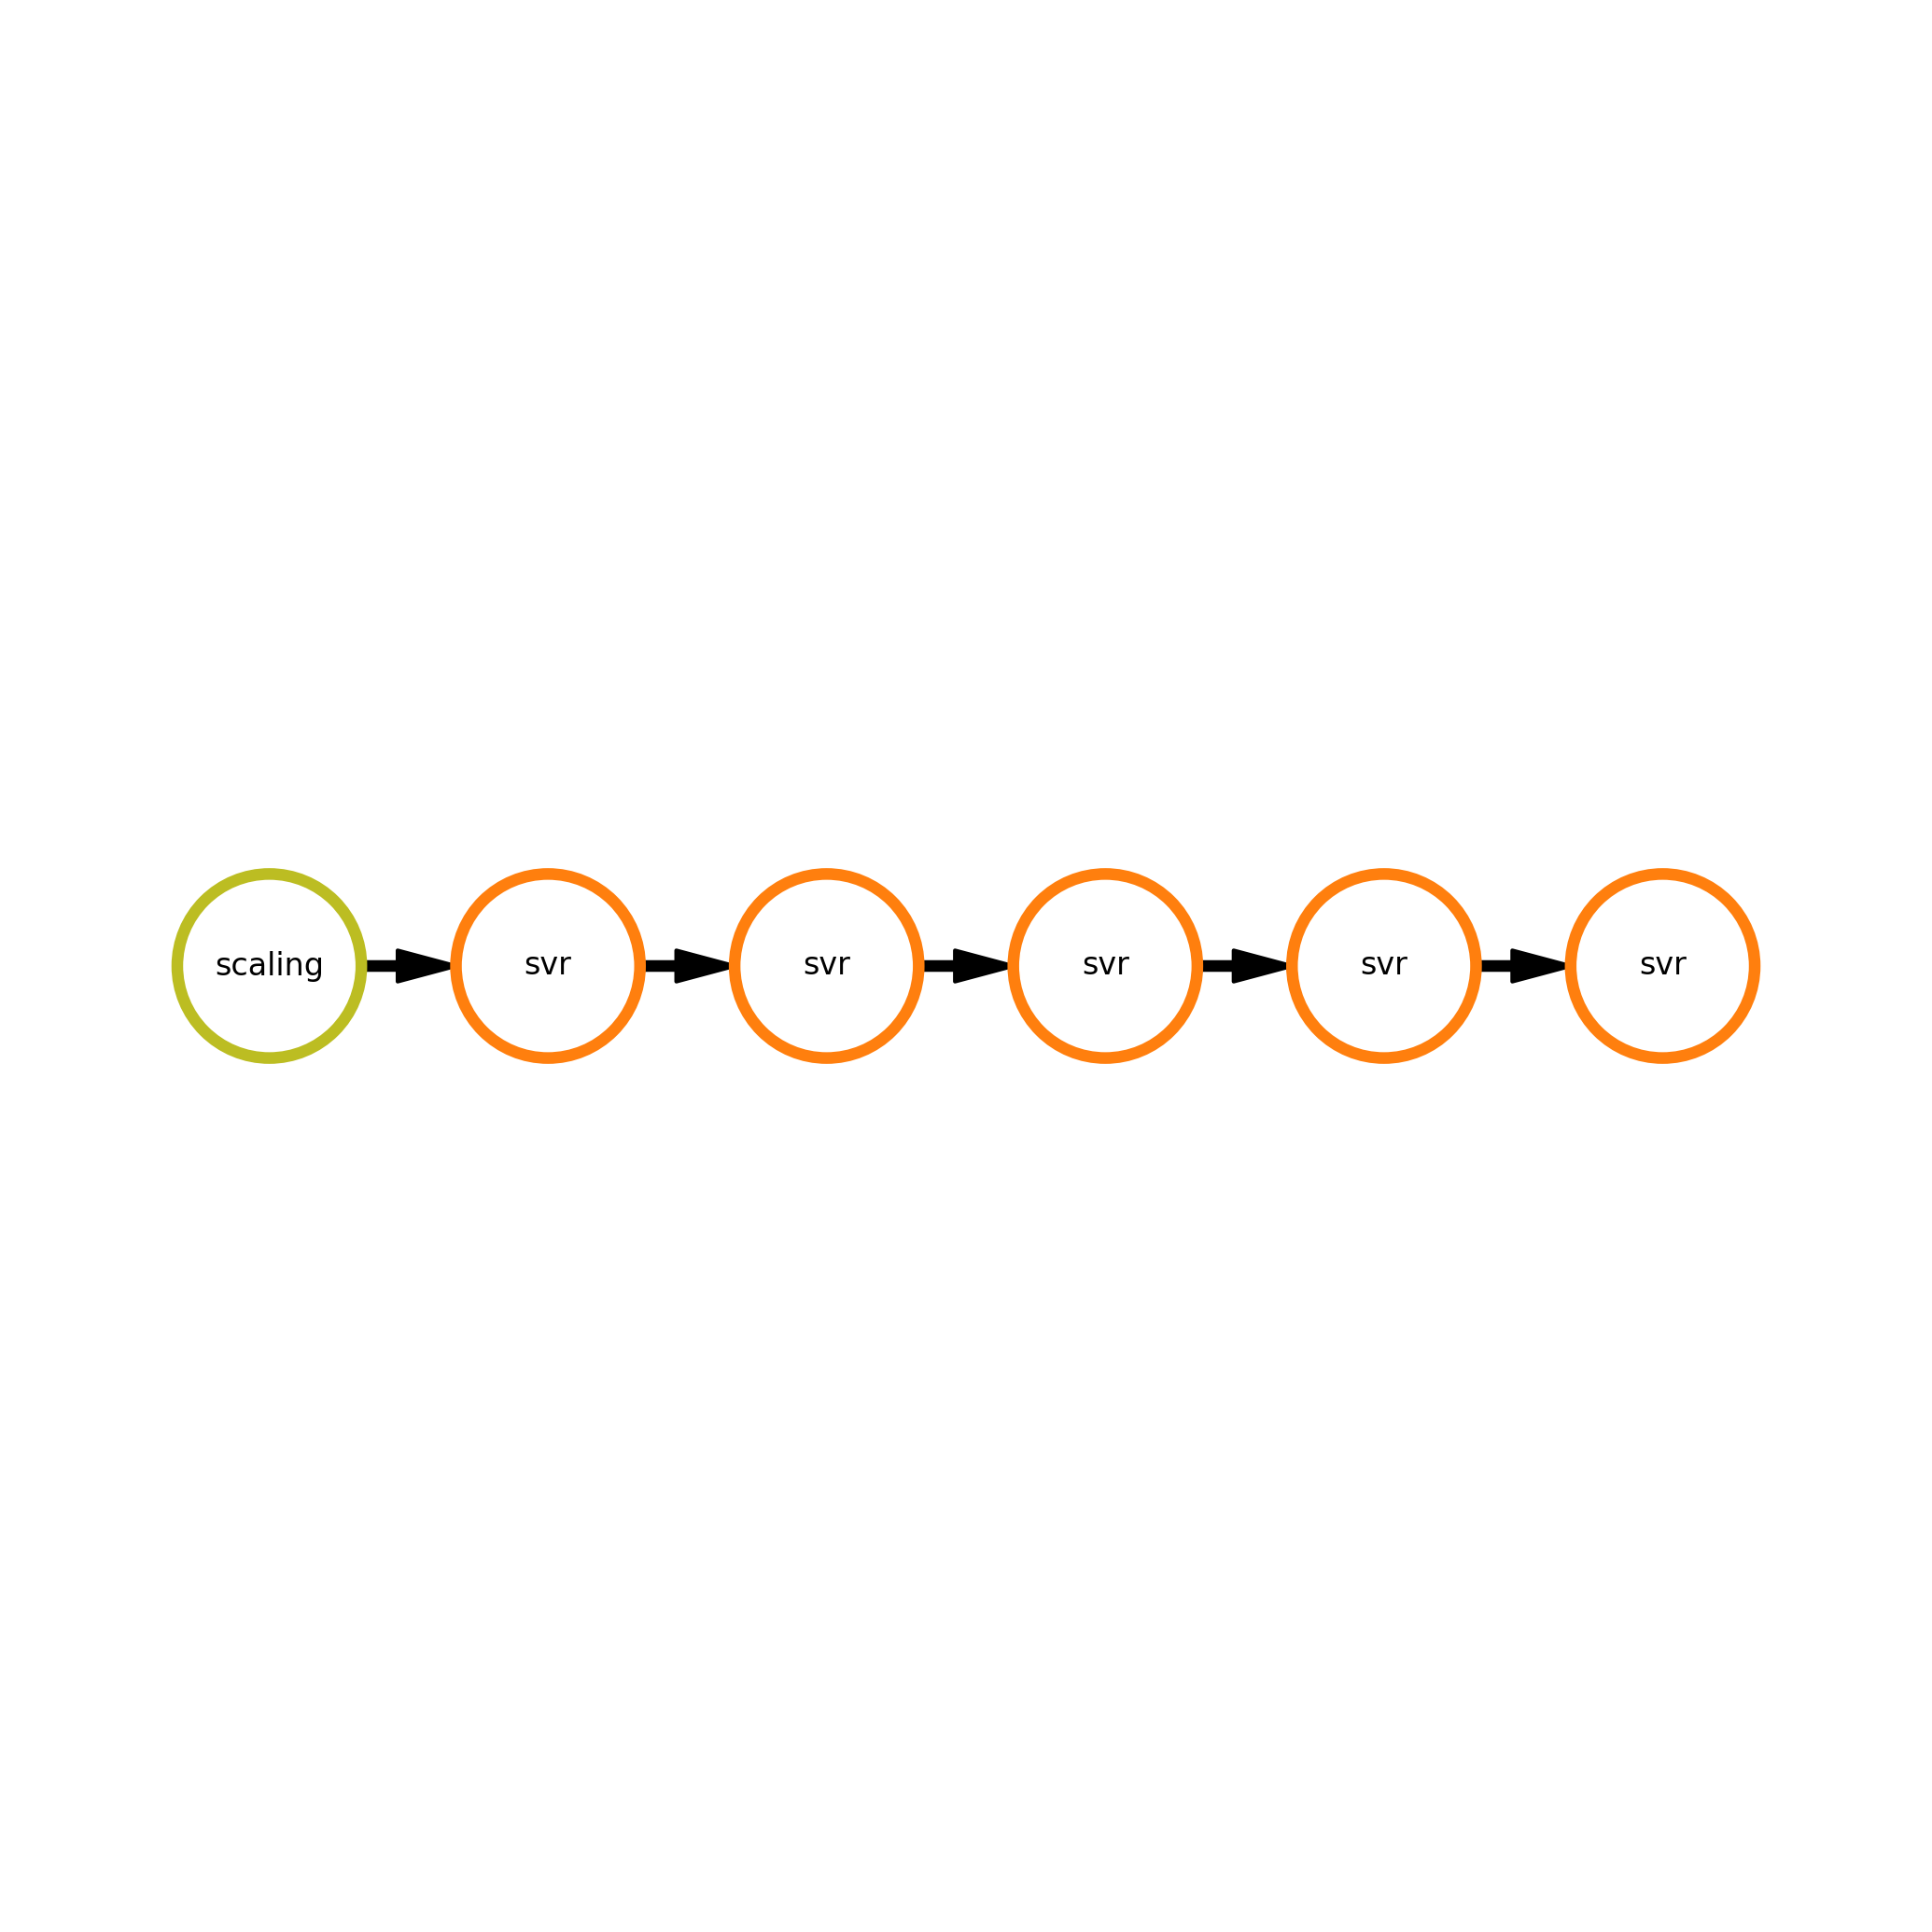

In [183]:
model_oneparam = Fedot(problem='regression', timeout=5, n_jobs=-1)
obtained_pipeline = model_oneparam.fit(features=X, target=y)
obtained_pipeline.show()


In [189]:
obtained_pipeline.save("models/fedot_oneparam.json")

('{\n    "total_pipeline_operations": [\n        "scaling",\n        "svr"\n    ],\n    "depth": 6,\n    "nodes": [\n        {\n            "operation_id": 5,\n            "operation_type": "scaling",\n            "operation_name": "ScalingImplementation",\n            "custom_params": {},\n            "params": {},\n            "nodes_from": [],\n            "fitted_operation_path": [\n                "fitted_operations",\n                "operation_5.pkl"\n            ],\n            "rating": null\n        },\n        {\n            "operation_id": 4,\n            "operation_type": "svr",\n            "operation_name": "LinearSVR",\n            "custom_params": {\n                "C": 0.7385604936238916,\n                "epsilon": 0.0441656460861396,\n                "loss": "epsilon_insensitive",\n                "tol": 0.0003559641770101305\n            },\n            "params": {\n                "C": 0.7385604936238916,\n                "epsilon": 0.0441656460861396,\n         

In [ ]:
model_oneparam.predict(np.array([X_test[0]]))

In [187]:
print("Scaling + RandomForestRegression results:")
y_pred = model_oneparam.predict(X_test)
r2_res = r2_score(y_test, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred)
print("R2    ", r2_res)
print("RMSE ", mse**(1/2))

Scaling + RandomForestRegression results:
R2     [0.08418659]
RMSE  288.92379275519556


Lets move to prediction of vector of values

In [190]:
def split_features_targets(df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy().reshape(window*13))
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = split_features_targets(dinam_fact_df)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

2022-11-07 19:37:40,364 - ApiComposer - Initial pipeline was fitted in 0.9 sec.
2022-11-07 19:37:40,368 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-07 19:37:40,387 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-11-07 19:40:36,185 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [02:55<?, ?gen/s]

2022-11-07 19:40:36,192 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


  0%|          | 85/100000 [02:04<40:34:14,  1.46s/trial, best loss: 73.44299483824106]
2022-11-07 19:42:42,074 - ApiComposer - Hyperparameters tuning finished
2022-11-07 19:42:42,582 - ApiComposer - Model generation finished
2022-11-07 19:42:42,632 - FEDOT logger - Final pipeline was fitted
2022-11-07 19:42:42,636 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rfr]}


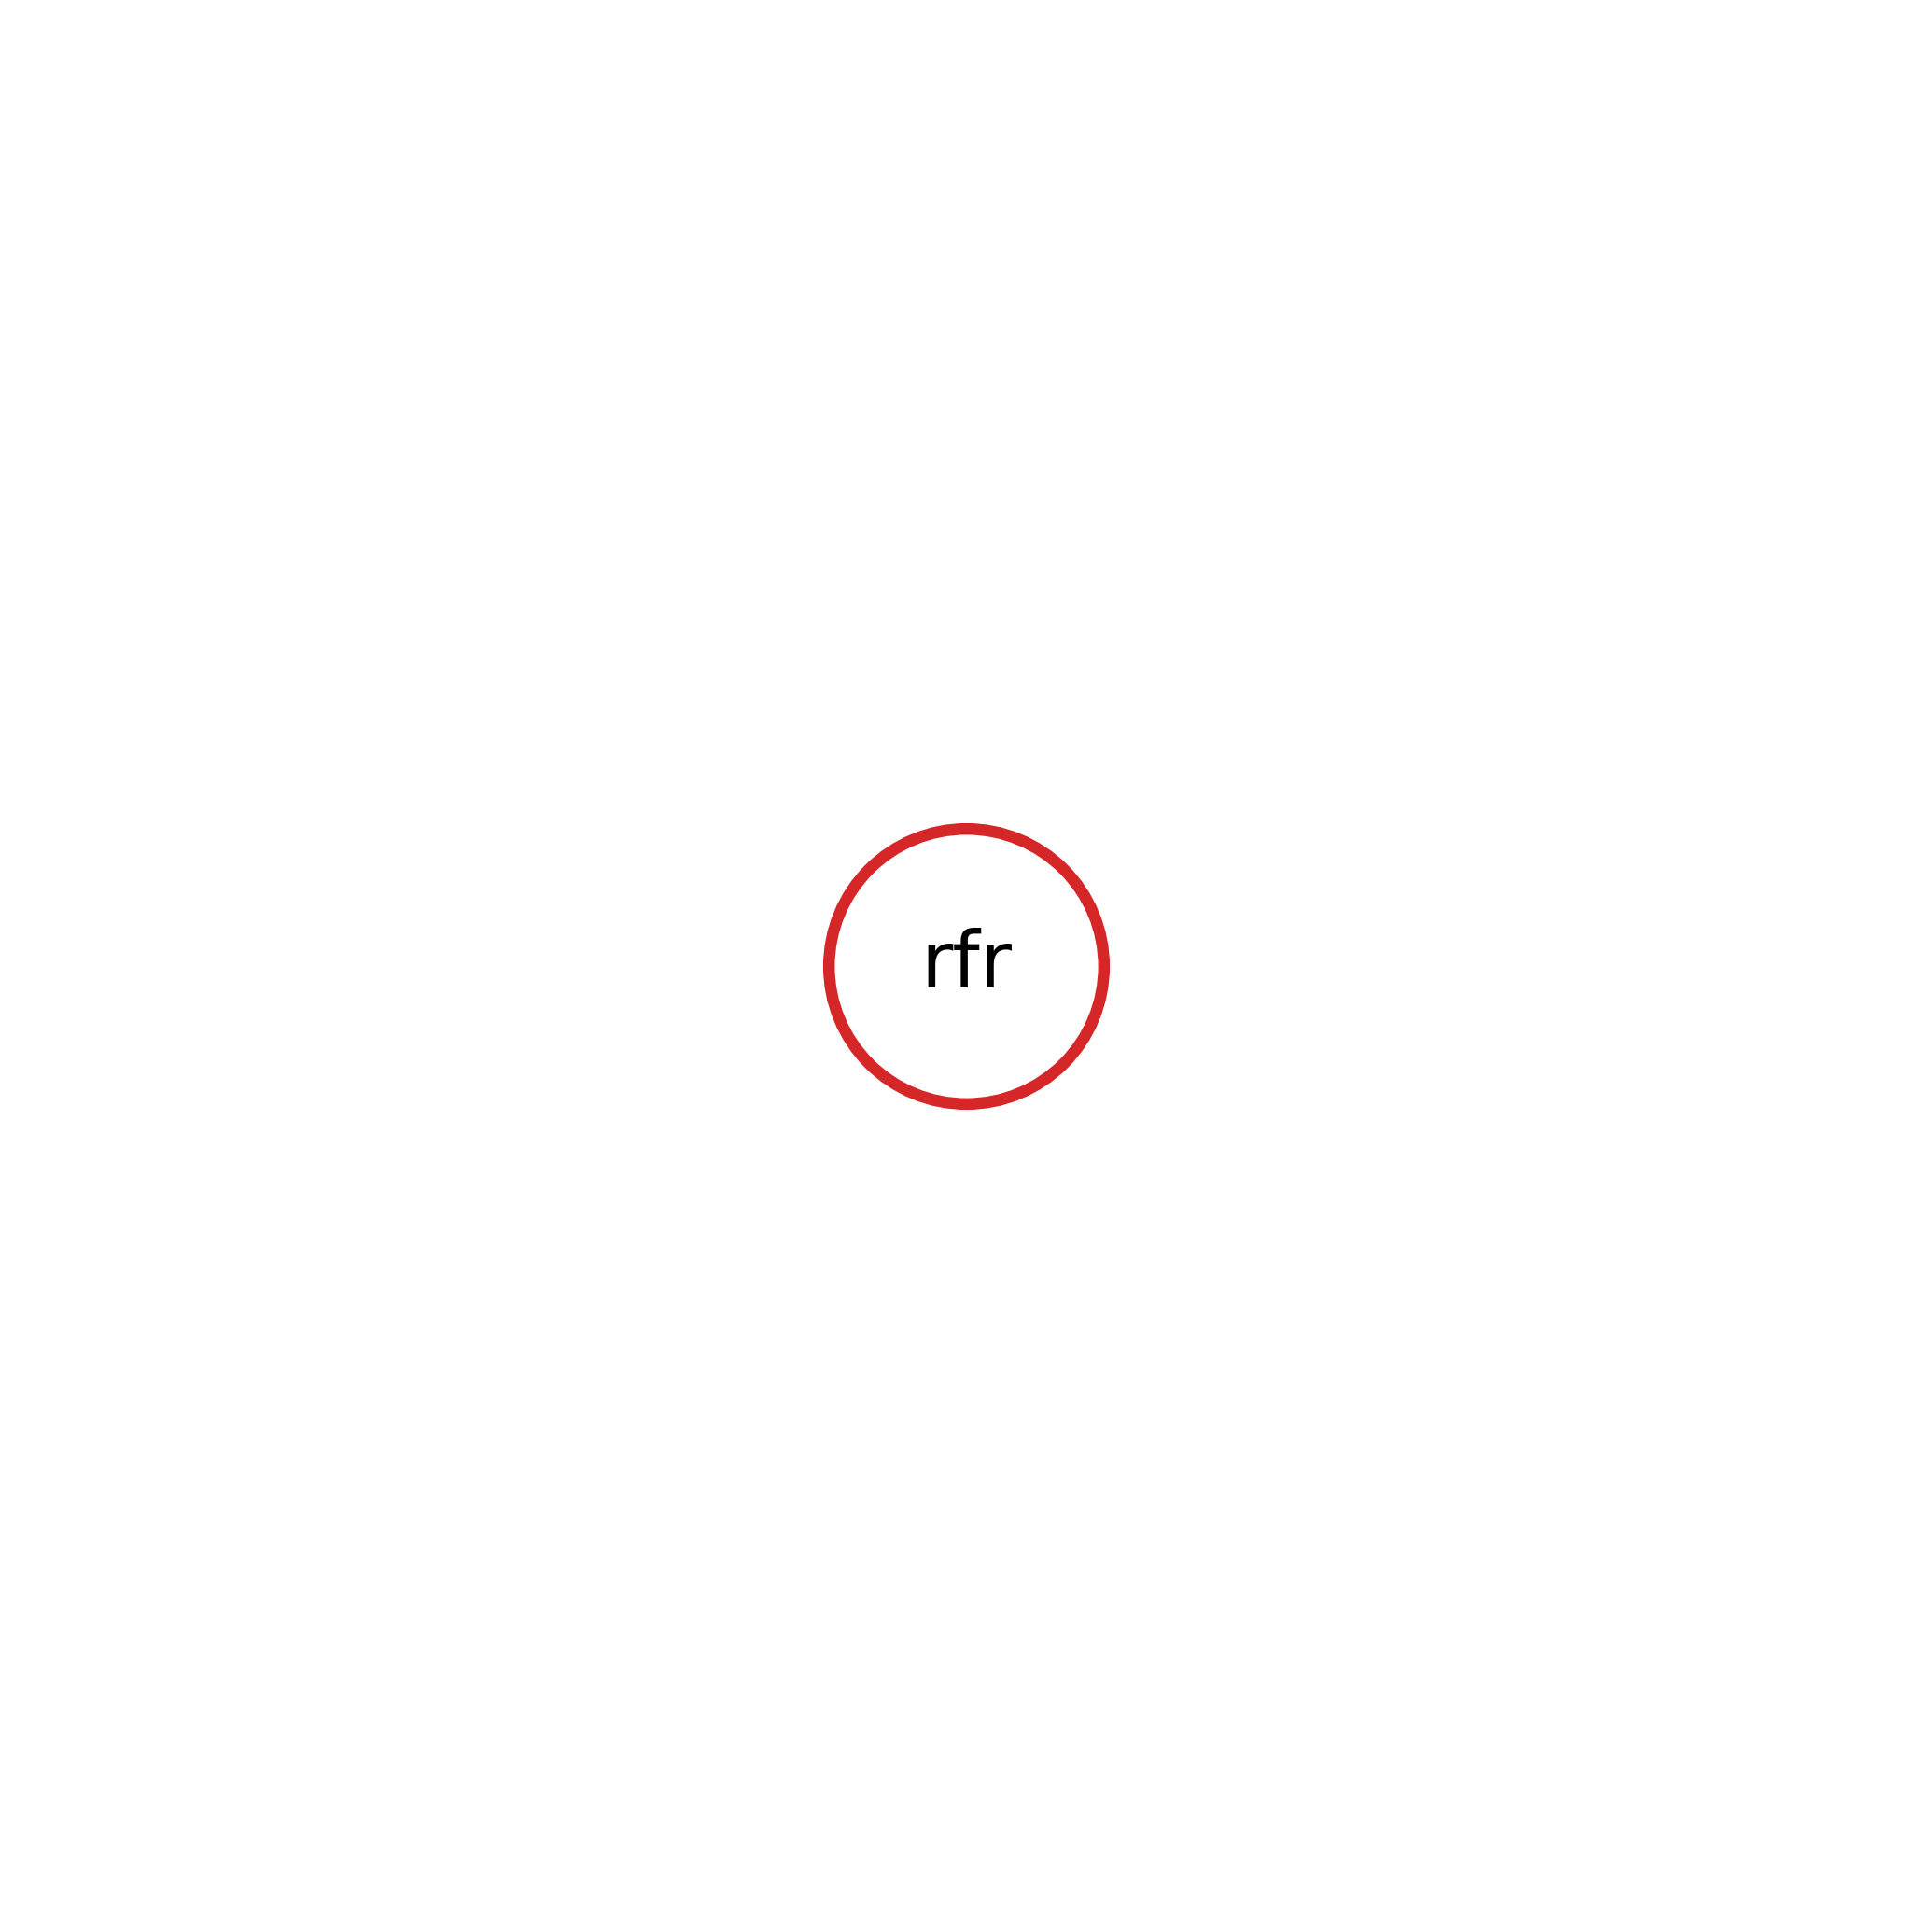

('{\n    "total_pipeline_operations": [\n        "rfr"\n    ],\n    "depth": 1,\n    "nodes": [\n        {\n            "operation_id": 0,\n            "operation_type": "rfr",\n            "operation_name": "RandomForestRegressor",\n            "custom_params": {\n                "n_jobs": -1,\n                "bootstrap": true,\n                "max_features": 0.05269130268903536,\n                "min_samples_leaf": 15,\n                "min_samples_split": 6,\n                "n_estimators": 100\n            },\n            "params": {\n                "n_jobs": -1,\n                "bootstrap": true,\n                "max_features": 0.05269130268903536,\n                "min_samples_leaf": 15,\n                "min_samples_split": 6,\n                "n_estimators": 100\n            },\n            "nodes_from": [],\n            "fitted_operation_path": [\n                "fitted_operations",\n                "operation_0.pkl"\n            ],\n            "rating": null\n        }

In [191]:
model_vec = Fedot(problem='regression', timeout=5, n_jobs=-1)
obtained_pipeline = model_vec.fit(features=X, target=y)
obtained_pipeline.show()
obtained_pipeline.save("models/fedot_vec_prediction")

In [193]:
print("vector prediction")
y_pred = model_vec.predict(X_test)
r2_res = r2_score(y_test, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred)
display(pd.DataFrame(data=r2_res.reshape(1, 13), columns=dinam_fact_df.columns, index=["R2"]))
print("RMSE ", mse**(1/2))

vector prediction


ValueError: y_true and y_pred have different number of output (13!=1)

Now we will try to add some statical facts. Age, Medicines, Treatments

In [194]:
def split_features_targets(df, dinam_fact_df, column, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        sample_data = dinam_fact_df.loc[(i, 0): (i, window-1)].to_numpy().reshape(window*13) # facts
        sample_data = np.append(sample_data, df.loc[(i, 0): (i, window-1)].iloc[:, 43:47].to_numpy().reshape(window*4)) #controls
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[:29].to_numpy()) #medicines
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[42]) #age
        X.append(sample_data)
        y.append(dinam_fact_df.loc[(i, window)][column])
    return np.array(X), np.array(y)

X, y = split_features_targets(df, dinam_fact_df, "АСТ_dinam_fact")
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

In [195]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (477, 81)
Shape of y:  (477,)


In [196]:
model_2 = Fedot(problem='regression', timeout=5)
obtained_pipeline = model_2.fit(features=X, target=y)
obtained_pipeline.show()

2022-11-07 21:36:36,046 - ApiComposer - Initial pipeline was fitted in 0.7 sec.
2022-11-07 21:36:36,052 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-07 21:36:36,064 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\sklearn\decomposition\_fastica.p

2022-11-07 21:39:17,725 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [02:41<?, ?gen/s]

2022-11-07 21:39:17,732 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


  0%|          | 13/100000 [02:25<311:23:24, 11.21s/trial, best loss: 61.524969629994814]
2022-11-07 21:41:51,775 - ApiComposer - Hyperparameters tuning finished
2022-11-07 21:41:52,274 - ApiComposer - Model generation finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 477 but corresponding boolean dimension is 382

In [ ]:
print("Add static variables:")
y_pred = model_2.predict(X_test)
r2_res = r2_score(y_test, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_test, y_pred)
display(pd.DataFrame(data=r2_res.reshape(1, 13), columns=dinam_fact_df.columns, index=["R2"]))
print("RMSE ", mse**(1/2))